<a href="https://colab.research.google.com/github/JoselitoAndre/Atividade-de-Detec-o-de-Pothole-com-YOLOv3/blob/main/Atividade_de_Detec%C3%A7%C3%A3o_de_Pothole_com_YOLOv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atividade de Detecção de Pothole com YOLOv3

### Aluno: Joselito André Araújo
### Professor: Doglas

<img src="https://cimg0.ibsrv.net/cimg/www.autocreditexpress.com/750x300_100-1/252/04-23-2019-Hit-a-Pothole-Damage-Could-Be-Done-Banner-423252.jpg" width="700">


O modelo é pré-treinado no conjunto de dados COCO. A estrutura usada para o treinamento é Darknet. Irá percorrer as seguintes etapas:

*   Instale as bibliotecas (Darknet, etc.)
*   Clone o repo do github e substitua os dados de treinamento do repo pelos seus dados (do Google Drive ou do próprio repo - o que é mais rápido)
*   Treine o modelo nas novas imagens
*   Execute inferência em algumas imagens para ver o que o modelo pode detectar
*   Converta o modelo para Representação Intermediária OpenVINO
*   Para executar o modelo em módulos DepthAI, compile o IR obtido acima em um arquivo .blob 

## PASSO 1 Instalando Darknet


In [1]:
%cd /content
!rm -r darknet/
!git clone https://github.com/AlexeyAB/darknet.git
%cd darknet
import re
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
# !sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!make
!chmod +x ./darknet


/content
rm: cannot remove 'darknet/': No such file or directory
Cloning into 'darknet'...
remote: Enumerating objects: 15185, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 15185 (delta 58), reused 70 (delta 31), pack-reused 15073
Receiving objects: 100% (15185/15185), 13.58 MiB | 17.46 MiB/s, done.
Resolving deltas: 100% (10304/10304), done.
/content/darknet
mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: v

In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
import tensorflow as tf
tf.__version__

'1.15.2'

In [4]:
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()
  
  


## Clonando o repositório auxiliar

In [5]:
repo_url = 'https://github.com/GotG/yolotinyv3_medmask_demo'
import os
%cd /content
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))
%rm -r {repo_dir_path}
!git clone {repo_url}
%cd {repo_dir_path}


/content
rm: cannot remove '/content/yolotinyv3_medmask_demo': No such file or directory
Cloning into 'yolotinyv3_medmask_demo'...
remote: Enumerating objects: 1733, done.
remote: Total 1733 (delta 0), reused 0 (delta 0), pack-reused 1733
Receiving objects: 100% (1733/1733), 208.88 MiB | 22.52 MiB/s, done.
Resolving deltas: 100% (120/120), done.
Checking out files: 100% (1537/1537), done.
/content/yolotinyv3_medmask_demo


In [6]:
from google.colab import drive
drive.mount('/content/drive')

if (True):
  #remove a pasta obj
  !rm -rf /content/yolotinyv3_medmask_demo/obj
  #copia imagens para a pasta obj
  #Isso pode levar alguns minutos, dependendo do tamanho do conjunto de dados. 
  !cp -rf '/content/drive/My Drive/datasets/medmask_yolo/obj' '/content/yolotinyv3_medmask_demo/obj'

Mounted at /content/drive
cp: cannot stat '/content/drive/My Drive/datasets/medmask_yolo/obj': No such file or directory


## Alterando os rótulos em obj.names para nossos rótulos atuais

In [7]:
labels_path = '/content/yolotinyv3_medmask_demo/obj.names'
#make a list of your labels
labels = ['macao','laranja', 'banana','pothole']
# labels = ['good','bad']

with open(labels_path, 'w') as f:

    f.write('\n'.join(labels))

#check that the labels file is correct
!cat /content/yolotinyv3_medmask_demo/obj.names

macao
laranja
banana
pothole

## Alterando o número de classes em obj.data..
Os caminhos são relativos, portanto, não há alteração, desde que a pasta /file structure/names are not changed.

In [8]:
import re
objdata = '/content/yolotinyv3_medmask_demo/obj.data'
with open(objdata) as f:
    s = f.read()

#O número de classes é deve ser igual ao número de rótulos.
num_classes = len(labels)   
s = re.sub('classes = \d*','classes = ' + str(num_classes),s)

with open(objdata, 'w') as f:
  f.write(s)
!cat /content/yolotinyv3_medmask_demo/obj.data

classes= 4
train  = /content/yolotinyv3_medmask_demo/train.txt
valid  = /content/yolotinyv3_medmask_demo/valid.txt
names = /content/yolotinyv3_medmask_demo/obj.names
backup = backup/

## Criando um arquivo train.txt, valid.txt e test.txt para as imagens da obj.

Usaremos um script que divide as imagens com base em uma porcentagem especificada e as grava nos arquivos train.txt, valid.txt e test.txt.

In [9]:
%cd ../yolotinyv3_medmask_demo/

/content/yolotinyv3_medmask_demo


In [10]:
# Neste caso, usamos 90 por cento das imagens para treinamento
# 5 por cento para validação, 5 para teste.

!python3 folder2textYolo.py 90 5 /content/yolotinyv3_medmask_demo/obj

Your image file extension is: .jpg
Number of images: 65
Number of images used for training 59
Number of images used for validation 3
Number of images used for testing 3


## A última coisa que precisamos mudar é o arquivo yolov3-tiny_obj.cfg.

Existem vários parâmetros importantes aqui. Eles controlam vários aspectos do processo de treinamento. Vamos imprimir as primeiras linhas e dar uma olhada


In [11]:
!head -n 24 /content/yolotinyv3_medmask_demo/yolov3-tiny_obj.cfg 


[net]
# Testing
#batch=1
#subdivisions=1
# Training
batch=64
subdivisions=16
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 4000
policy=steps
steps=3200,3600
scales=.1,.1



In [12]:
# definir o número de max_batches - mínimo 2.000 por classe:
max_batch=4000
# calcule os valores das 2 etapas:
step1 = 0.8 * max_batch
step2 = 0.9 * max_batch

# também precisamos ajustar o número de classes e um parâmetro chamado tamanho do filtro
# que estão ambos dentro da estrutura do modelo


num_filters = (num_classes + 5) * 3


cfg_file = '/content/yolotinyv3_medmask_demo/yolov3-tiny_obj.cfg'


with open(cfg_file) as f:
    s = f.read()

s = re.sub('max_batches = \d*','max_batches = '+str(max_batch),s)
s = re.sub('steps=\d*,\d*','steps='+"{:.0f}".format(step1)+','+"{:.0f}".format(step2),s)
s = re.sub('classes=\d*','classes='+str(num_classes),s)
s = re.sub('pad=1\nfilters=\d*','pad=1\nfilters='+"{:.0f}".format(num_filters),s)


with open(cfg_file, 'w') as f:
  
  f.write(s)



### Vamos olhar  para a configuração

In [13]:
!head -n 24 /content/yolotinyv3_medmask_demo/yolov3-tiny_obj.cfg 


[net]
# Testing
#batch=1
#subdivisions=1
# Training
batch=64
subdivisions=16
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 4000
policy=steps
steps=3200,3600
scales=.1,.1



In [14]:
!tail -n 64 /content/yolotinyv3_medmask_demo/yolov3-tiny_obj.cfg 


stride=1
pad=1
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters=27
activation=linear



[yolo]
mask = 3,4,5
anchors = 10,14,  23,27,  37,58,  81,82,  135,169,  344,319
classes=4
num=6
jitter=.3
ignore_thresh = .7
truth_thresh = 1
random=1

[route]
layers = -4

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[upsample]
stride=2

[route]
layers = -1, 8

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters=27
activation=linear

[yolo]
mask = 1,2,3
anchors = 10,14,  23,27,  37,58,  81,82,  135,169,  344,319
classes=4
num=6
jitter=.3
ignore_thresh = .7
truth_thresh = 1
random=1


# Treinando o modelo

Ao executar o comando a seguir, vamos iniciar o treinamento.

In [15]:
%cd /content/darknet/

/content/darknet


In [16]:
!./darknet detector train /content/yolotinyv3_medmask_demo/obj.data /content/yolotinyv3_medmask_demo/yolov3-tiny_obj.cfg /content/yolotinyv3_medmask_demo/yolov3-tiny.conv.15 -dont_show -ext_output -map

A saída de streaming foi truncada nas últimas 5000 linhas.
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 16 Avg (IOU: 0.785958), count: 15, class_loss = 1.288485, iou_loss = 0.713251, total_loss = 2.001736 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 23 Avg (IOU: 0.723256), count: 42, class_loss = 3.134836, iou_loss = 2.953338, total_loss = 6.088175 
 total_bbox = 1990728, rewritten_bbox = 0.340328 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 16 Avg (IOU: 0.809589), count: 10, class_loss = 0.493962, iou_loss = 0.326238, total_loss = 0.820200 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 23 Avg (IOU: 0.780362), count: 18, class_loss = 1.934809, iou_loss = 0.823161, total_loss = 2.757970 
 total_bbox = 1990756, rewritten_bbox = 0.340323 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 16 Avg (IOU: 0.822558), count: 5, class_loss = 0.156502, iou_loss = 0.147451, total_loss = 0.3

## Verificando o desempenho do modelo

As métricas são executadas nas imagens de validação, de modo que podem não ser totalmente representativas, apenas indicativas.

In [17]:
!./darknet detector map /content/yolotinyv3_medmask_demo/obj.data /content/yolotinyv3_medmask_demo/yolov3-tiny_obj.cfg "/content/darknet/backup/yolov3-tiny_obj_best.weights" -points 0

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     16       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  16 0.150 BF
   1 max                2x 2/ 2    416 x 416 x  16 ->  208 x 208 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    208 x 208 x  16 ->  208 x 208 x  32 0.399 BF
   3 max                2x 2/ 2    208 x 208 x  32 ->  104 x 104 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  64 0.399 BF
   5 max                2x 2/ 2    104 x 104 x  64 ->   52 x  52 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     52 x  52 x  64 ->   52 x  52 x 128 0.399 BF
   7 max                2x 2/ 2     52 x  52 x 128 ->   26 x  26 x 128 0.000 BF
   8 conv    256   

## Executando a detecção em uma imagem. A imagem escolhida é uma das imagens de teste do arquivo test.txt

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     16       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  16 0.150 BF
   1 max                2x 2/ 2    416 x 416 x  16 ->  208 x 208 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    208 x 208 x  16 ->  208 x 208 x  32 0.399 BF
   3 max                2x 2/ 2    208 x 208 x  32 ->  104 x 104 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  64 0.399 BF
   5 max                2x 2/ 2    104 x 104 x  64 ->   52 x  52 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     52 x  52 x  64 ->   52 x  52 x 128 0.399 BF
   7 max                2x 2/ 2     52 x  52 x 128 ->   26 x  26 x 128 0.000 BF
   8 conv    256   

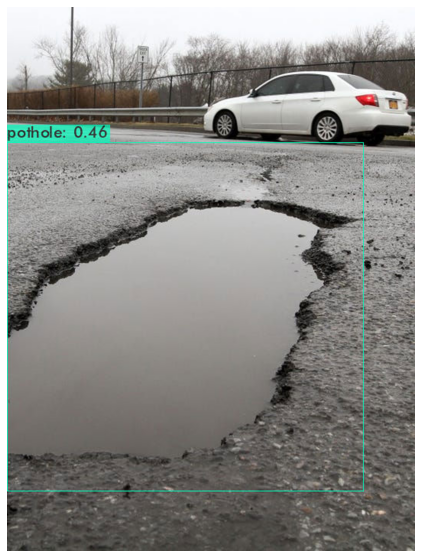

In [18]:
!./darknet detector test /content/yolotinyv3_medmask_demo/obj.data  /content/yolotinyv3_medmask_demo/yolov3-tiny_obj.cfg  "/content/darknet/backup/yolov3-tiny_obj_best.weights" /content/yolotinyv3_medmask_demo/obj/56.jpg -ext_output
imShow('predictions.jpg')

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     16       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  16 0.150 BF
   1 max                2x 2/ 2    416 x 416 x  16 ->  208 x 208 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    208 x 208 x  16 ->  208 x 208 x  32 0.399 BF
   3 max                2x 2/ 2    208 x 208 x  32 ->  104 x 104 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  64 0.399 BF
   5 max                2x 2/ 2    104 x 104 x  64 ->   52 x  52 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     52 x  52 x  64 ->   52 x  52 x 128 0.399 BF
   7 max                2x 2/ 2     52 x  52 x 128 ->   26 x  26 x 128 0.000 BF
   8 conv    256   

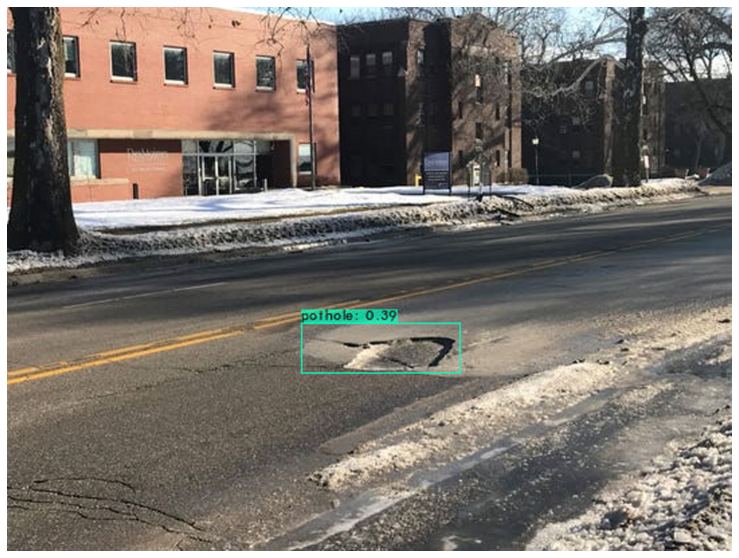

In [20]:
!./darknet detector test /content/yolotinyv3_medmask_demo/obj.data  /content/yolotinyv3_medmask_demo/yolov3-tiny_obj.cfg  "/content/darknet/backup/yolov3-tiny_obj_best.weights" /content/yolotinyv3_medmask_demo/obj/25.jpg -ext_output
imShow('predictions.jpg')

## Copiando os melhores pesos para o google drive.


In [21]:
!cp /content/darknet/backup/yolov3-tiny_obj_best.weights  '/content/drive/My Drive/'

# Convertendo o modelo para que ele possa ser usado no DepthAI
Isso requer três etapas:
1. Converter modelo em modelo congelado do Tensorflow
2. Converter modelo Tf para arquivos OpenVINO IR .xml e .bin
3. Compile um blob dos arquivos IR. O blob pode ser usado para inferência nos módulos DepthAI.

### Converter modelo YOLO em modelo frozen do Tensorflow


In [22]:
%cd /content
#clone a repo that helps with the conversion
!git clone https://github.com/mystic123/tensorflow-yolo-v3.git
%cd tensorflow-yolo-v3/
!git checkout ed60b90

/content
Cloning into 'tensorflow-yolo-v3'...
remote: Enumerating objects: 219, done.
remote: Total 219 (delta 0), reused 0 (delta 0), pack-reused 219
Receiving objects: 100% (219/219), 57.63 KiB | 491.00 KiB/s, done.
Resolving deltas: 100% (112/112), done.
/content/tensorflow-yolo-v3
Note: checking out 'ed60b90'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at ed60b90 Merge pull request #53 from alexzhangxx/small_change


In [23]:
!python3 convert_weights_pb.py --class_names /content/yolotinyv3_medmask_demo/obj.names --data_format NHWC --weights_file /content/darknet/backup/yolov3-tiny_obj_best.weights --tiny


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0630 14:51:58.162177 139930727188352 module_wrapper.py:139] From convert_weights_pb.py:38: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.


W0630 14:51:58.169474 139930727188352 module_wrapper.py:139] From convert_weights_pb.py:40: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

Instructions for updating:
Please use `layer.__call__` method instead.
W0630 14:51:58.172419 139930727188352 deprecation.py:323] From /tensorflow-1.15.2/python3.7/tensorflow_core/contrib/layers/python/layers/layers.py:1057: Layer.apply (from tensorflow.python.keras.engine.

### Instale o OpenVINO 21.03

In [24]:
%cd /content

/content


In [25]:
import os
from urllib.parse import urlparse

## instalar ferramentas. O download do Open Vino leva algum tempo - é de aproximadamente 400 MB
!sudo apt-get install -y pciutils cpio
!sudo apt autoremove

## baixar arquivos de instalação
url = "https://registrationcenter-download.intel.com/akdlm/irc_nas/17662/l_openvino_toolkit_p_2021.3.394.tgz"
!wget {url}

## Pegue o nome do tgz
parsed = urlparse(url)
openvino_tgz = os.path.basename(parsed.path)
openvino_folder = os.path.splitext(openvino_tgz)[0]

## Extraia e instale o openvino
!tar xf {openvino_tgz}
%cd {openvino_folder}
!./install_openvino_dependencies.sh && \
    sed -i 's/decline/accept/g' silent.cfg && \
    ./install.sh --silent silent.cfg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libpci3
Suggested packages:
  libarchive1
The following NEW packages will be installed:
  cpio libpci3 pciutils
0 upgraded, 3 newly installed, 0 to remove and 39 not upgraded.
Need to get 368 kB of archives.
After this operation, 1,786 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 cpio amd64 2.12+dfsg-6ubuntu0.18.04.1 [86.2 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libpci3 amd64 1:3.5.2-1ubuntu1.1 [24.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 pciutils amd64 1:3.5.2-1ubuntu1.1 [257 kB]
Fetched 368 kB in 1s (346 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 

### Converter modelo TF congelado para openvino 20.01 IRv10
--input model é o caminho para o modelo frozen de cima

--output_dir é onde queremos salvar os arquivos IR convertidos: .xml .bin e .mapping. nós salvá-lo em TinyIR no /content/yolotinyv3_medmask_demo directory

In [26]:
%cd ..

/content


In [27]:
tiny_yolo_json = '/content/yolotinyv3_medmask_demo/yolo_v3_tiny.json'

with open(tiny_yolo_json) as f:
    s = f.read()
s = re.sub('"classes": \d*','"classes": ' + str(len(labels)),s)
with open(tiny_yolo_json, 'w') as f:
  f.write(s)
#Check that the number of classes is correct (same as the number of your training labels)|
!cat /content/yolotinyv3_medmask_demo/yolo_v3_tiny.json

[
  {
    "id": "TFYOLOV3",
    "match_kind": "general",
    "custom_attributes": {
      "classes": 4,
      "anchors": [10, 14, 23, 27, 37, 58, 81, 82, 135, 169, 344, 319],
      "coords": 4,
      "num": 6,
      "masks": [[3, 4, 5], [1, 2, 3]],
      "entry_points": ["detector/yolo-v3-tiny/Reshape", "detector/yolo-v3-tiny/Reshape_4"]
    }
  }
]

In [28]:

# Get openvino installation path
openvino = !find /opt/intel -type d -name openvino*

!python -mpip install -r {openvino[0]}/deployment_tools/model_optimizer/requirements.txt

!source {openvino[0]}/bin/setupvars.sh && \
    python {openvino[0]}/deployment_tools/model_optimizer/mo.py \
--input_model /content/tensorflow-yolo-v3/frozen_darknet_yolov3_model.pb \
--tensorflow_use_custom_operations_config /content/yolotinyv3_medmask_demo/yolo_v3_tiny.json \
--batch 1 \
--data_type FP16 \
--reverse_input_channel \
--output_dir /content/yolotinyv3_medmask_demo/TinyIR

Ignoring tensorflow: markers 'python_version >= "3.8"' don't match your environment
     |████████████████████████████████| 68.7MB 45kB/s 
     |████████████████████████████████| 20.1MB 1.4MB/s 
     |████████████████████████████████| 12.2MB 257kB/s 
     |████████████████████████████████| 143kB 57.2MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7557 sha256=311c9fecd1e3faab6a5a70c746dfcd412689cbc80056a47d47b50c3b0b6045a5
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: lucid 0.3.10 requires umap-learn, which is not installed.
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.6 which is incompatible.
ERROR: kapre 0.3.5 has requirement tensorflow>=2.0.0, but you'll have tensorflow 1.15.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatibl

## Agora compilamos o modelo IR em um .blob para uso em módulos / plataforma DepthAI

### Salvamos o blob no diretório IR acima, correspondendo ao parâmetro --output_dir acima. 
O nome do arquivo e localização do blob serão

 `/content/yolotinyv3_medmask_demo/TinyIR/frozen_darknet_yolov3_model.blob`

In [29]:
blob_dir = "/content/yolotinyv3_medmask_demo/TinyIR/"
binfile = "/content/yolotinyv3_medmask_demo/TinyIR/frozen_darknet_yolov3_model.bin"
xmlfile = "/content/yolotinyv3_medmask_demo/TinyIR/frozen_darknet_yolov3_model.xml"

!python -m pip install blobconverter

import blobconverter
blob_path = blobconverter.from_openvino(
    xml=xmlfile,
    bin=binfile,
    data_type="FP16",
    shaves=5,
)
from google.colab import files
files.download(blob_path) 

     |████████████████████████████████| 133kB 6.8MB/s 
     |████████████████████████████████| 81kB 7.5MB/s 
     |████████████████████████████████| 7.7MB 10.5MB/s 
     |████████████████████████████████| 133kB 40.2MB/s 
ERROR: kapre 0.3.5 has requirement tensorflow>=2.0.0, but you'll have tensorflow 1.15.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.26.6
    Uninstalling urllib3-1.26.6:
      Successfully uninstalled urllib3-1.26.6
[==================================================]
Done


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Execute o blob no DepthAI

Para usar este blob com DepthAI:

- Clone depthai demo scrip

    ```
    $ git clone https://github.com/luxonis/depthai.git
    ```
- Requisitos de instalação

    ```
    $ python3 install_requirements.py
    ```
- Crie um novo diretório de modelo e insira o blob

    ```
    $ mkdir resources/nn/custom_tinyyolo
    $ mv <downloaded_blob> resources/nn/custom_tinyyolo/
    ```

- Copiar arquivo de configuração do modelo yolo

    ```
    $ cp resources/nn/yolo-v3/yolo-v3.json resources/nn/custom_tinyyolo/custom_tinyyolo.json
    ```

- Execute o script de demonstração

    ```
    $ python3 depthai_demo.py -cnn custom_tinyyolo
    ```


In [30]:
#Comprima a pasta com o modelo Tensorflow e a pasta OpenVINO IR_V10 e faça o download localmente.
!tar czvf fine_tuned_model.tar.gz {blob_dir}

tar: Removing leading `/' from member names
/content/yolotinyv3_medmask_demo/TinyIR/
/content/yolotinyv3_medmask_demo/TinyIR/frozen_darknet_yolov3_model.bin
/content/yolotinyv3_medmask_demo/TinyIR/frozen_darknet_yolov3_model.xml
/content/yolotinyv3_medmask_demo/TinyIR/frozen_darknet_yolov3_model.mapping


In [31]:
# baixe a pasta IRv10 compactada localmente
from google.colab import files
files.download("fine_tuned_model.tar.gz")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>